In [27]:
import random, statistics
from scipy.stats import t
from matplotlib import pyplot as plt

# Score Matching
スコアマッチングとは、スコア関数を最適化すること（と、ランジュバン・モンテカルロ）により、目的の確率分布からのサンプリングを行う手法である。

目的の確率分布を$p(x)$、そのスコア関数を$s(x)$とする。今、$\theta$をパラメータとして持つ関数（例えばニューラルネットワーク）を$\hat{s}_\theta(x)$とし、これを用いて$p(x)$からのサンプルを得ることを考えると、スコアマッチングは大きく分けて以下の２ステップで実行される。
1. $\hat{s}_\theta(x)$が$s(x)$に近づくように$\theta$を最適化する
2. ランジュバン・モンテカルロによってサンプリングを行う

## Explicit Score Matching

明示的スコアマッチングは、スコアマッチングの最も直接的なアプローチであり、真のスコア関数$s(x)$が既知であることを追加の仮定として、二乗和誤差を最小化することによって$\theta$の最適化を行う。

$$
\theta^{\text{ESM}} =  \argmin_\theta \frac{1}{2} \mathbb{E}_{x \sim p(x)} \left[ {\left|\left| \hat{s}_\theta(x) - s(x) \right|\right|}^2 \right]
$$

明示的スコアマッチングは、真のスコア関数$s(x)$が既知であるという非現実的な仮定に立脚する方法であるため、明らかに実用的ではない。

## Implicit Score Matching

暗黙的スコアマッチングは、真のスコア関数$s(x)$が未知である条件下で$\theta$を最適化する。

$$
\theta^{\text{ISM}} = \argmin_\theta \mathbb{E}_{x \sim p(x)} \left[ \frac{1}{2} {\left|\left| \hat{s}_\theta (x) \right|\right|}^2 + \text{tr} \left( \nabla_x \hat{s}_\theta (x) \right)\right]
$$

真のスコア関数$s(x)$が未知であっても最適化できる点が強力であるが、ヤコビ行列$\nabla_x \hat{s}_\theta (x)$のトレースを計算することが実用上コストの大きいものであった。
また、過学習が起こりやすいことも指摘されていた。

<details><summary>暗黙的スコアマッチングがスコアを推定できることの証明</summary><div>
証明には以下の４つの仮定を要する。

1. $p(x)$が微分可能
2. $\mathbb{E}_{x \sim p(x)} \left[ {\left|\left| s(x) \right|\right|}^2 \right]$が有限
3. 任意の$\theta$について$\mathbb{E}_{x \sim p(x)} \left[ {\left|\left| \hat{s}_\theta (x) \right|\right|}^2 \right]$が有限
4. $\lim_{||x|| \rightarrow \infty} \left[ p(x)\hat{s}_\theta (x) \right] = 0$

まず、明示的スコアマッチングの式を展開する。
$$
\begin{align*}
\frac{1}{2} \mathbb{E}_{x \sim p(x)} \left[ {\left|\left| \hat{s}_\theta(x) - s(x) \right|\right|}^2 \right] = \int_{\mathbb{R}^d} p(x) \left(  \frac{1}{2} {|| \hat{s}_\theta(x) ||}^2 - {\hat{s}_\theta(x)}^\top s(x) + \frac{1}{2} {|| s(x)||}^2 \right) dx
\end{align*}
$$

最右辺の各項に着目すると、第一項$(1/2) {|| \hat{s}_\theta(x) ||}^2$は暗黙的スコアマッチングの式の第一項と一致しており、また第三項は$\theta$を含まないため定数項として無視できる。
よって、最右辺第二項$-{\hat{s}_\theta(x)}^\top s(x)$が、暗黙的スコアマッチングの式の第二項$\text{tr} \left( \nabla_x \hat{s}_\theta (x) \right)$と等しい（少なくとも、定数の差しかない）ことを示せば良い。

---
第二項の内積を総和として表現すると、

$$
-\sum_{i} \int_{\mathbb{R}^d} p(x) \hspace{1mm} (s(x))_i \hspace{1mm} (\hat{s}_\theta (x))_i dx
$$

と書ける。ただし、$(s(x))_i, (\hat{s}_\theta (x))_i$はそれぞれ$s(x), \hat{s}_\theta (x)$の$i$番目の成分である。
ここで、$s(x)=\nabla_x \ln{(p(x))}$であることに注意すると、

$$
\begin{align*}
-\sum_{i} \int_{\mathbb{R}^d} p(x) \hspace{1mm} (\nabla_x \ln{(p(x))})_i \hspace{1mm} (\hat{s}_\theta (x))_i dx
 &= -\sum_{i} \int_{\mathbb{R}^d} p(x) \hspace{1mm} \frac{\partial \ln{p(x)}}{\partial x_i} \hspace{1mm} (\hat{s}_\theta (x))_i dx \\
 &= -\sum_{i} \int_{\mathbb{R}^d} p(x) \hspace{1mm}  \left( \frac{1}{p(x)} \frac{\partial p(x)}{\partial x_i} \right) \hspace{1mm} (\hat{s}_\theta (x))_i dx \\
 &= -\sum_{i} \int_{\mathbb{R}^d} \frac{\partial p(x)}{\partial x_i} \hspace{1mm} (\hat{s}_\theta (x))_i dx \\
\end{align*}
$$

と書ける。
よって、目標の項$\text{tr} \left( \nabla_x \hat{s}_\theta (x) \right)$も同様に総和として表現できることを考慮すれば、以下の等式を示すことができれば良いと言える。

$$
-\int_{\mathbb{R}^d} \frac{\partial p(x)}{\partial x_i} \hspace{1mm} (\hat{s}_\theta (x))_i dx = \int_{\mathbb{R}^d} \frac{\partial (\hat{s}_\theta (x))_i}{\partial x_i} \hspace{1mm} p(x) dx
$$

---
任意の微分可能な関数$f(x), g(x)$について、以下が成り立つ。
ここで、$x_{\backslash i}$は$x$の$i$番目以外の要素である。
証明は、$f(x)g(x)$を$x_i$について微分し、それを$x_i \in \mathbb{R}$について積分することで容易に与えられる。

$$
\lim_{x_i \rightarrow \infty} f(x_i, x_{\backslash i}) - \lim_{x_i \rightarrow -\infty} f(x_i, x_{\backslash i}) = \int_{-\infty}^{\infty} f(x) \frac{\partial g(x)}{\partial x_i} dx_i + \int_{-\infty}^{\infty} g(x) \frac{\partial f(x)}{\partial x_i} dx_i
$$

これを先の式に適用すると、

$$
\begin{align*}
-\int_{\mathbb{R}^d} \frac{\partial p(x)}{\partial x_i} \hspace{1mm} (\hat{s}_\theta (x))_i dx
 &= -\int_{\mathbb{R}^{d-1}}　\left( \int_{\mathbb{R}} \frac{\partial p(x)}{\partial x_i} \hspace{1mm} (\hat{s}_\theta (x))_i dx_i \right) dx_{\backslash i} \\
 &= -\int_{\mathbb{R}^{d-1}} \left( \lim_{x_i \rightarrow \infty} f(x_i, x_{\backslash i}) - \lim_{x_i \rightarrow -\infty} f(x_i, x_{\backslash i}) - \int_{\mathbb{R}} \frac{\partial (\hat{s}_\theta (x))_i}{\partial x_i} \hspace{1mm} p(x) dx_i \right) dx_{\backslash i} \\
 &= -\int_{\mathbb{R}^{d-1}} \left( 0 - 0 - \int_{\mathbb{R}} \frac{\partial (\hat{s}_\theta (x))_i}{\partial x_i} \hspace{1mm} p(x) dx_i \right) dx_{\backslash i} \quad \left( \because \lim_{||x|| \rightarrow \infty} \left[ p(x)\hat{s}_\theta (x) \right] = 0 \right) \\
 &= \int_{\mathbb{R}^d} \frac{\partial (\hat{s}_\theta (x))_i}{\partial x_i} \hspace{1mm} p(x) dx
\end{align*}
$$

---
まとめると、まず積の微分によって以下を得る。

$$
\begin{align*}
-\int_{\mathbb{R}^d} \frac{\partial p(x)}{\partial x_i} \hspace{1mm} (\hat{s}_\theta (x))_i dx &= \int_{\mathbb{R}^d} \frac{\partial (\hat{s}_\theta (x))_i}{\partial x_i} \hspace{1mm} p(x) dx \\
-\sum_{i} \int_{\mathbb{R}^d} \frac{\partial p(x)}{\partial x_i} \hspace{1mm} (\hat{s}_\theta (x))_i dx &= \sum_i \int_{\mathbb{R}^d} \frac{\partial (\hat{s}_\theta (x))_i}{\partial x_i} \hspace{1mm} p(x) dx \\
\end{align*}
$$

左辺は以下のように変形される。

$$
-\sum_{i} \int_{\mathbb{R}^d} \frac{\partial p(x)}{\partial x_i} \hspace{1mm} (\hat{s}_\theta (x))_i dx = -\sum_{i} \int_{\mathbb{R}^d} p(x) \hspace{1mm} (s(x))_i \hspace{1mm} (\hat{s}_\theta (x))_i dx = \int_{\mathbb{R}^d} p(x) \left(  - {\hat{s}_\theta(x)}^\top s(x) \right) dx
$$

一方右辺は以下のように変形される。

$$
\sum_i \int_{\mathbb{R}^d} \frac{\partial (\hat{s}_\theta (x))_i}{\partial x_i} \hspace{1mm} p(x) dx = \int_{\mathbb{R}^d} p(x) \left(  \text{tr} \left( \nabla_x \hat{s}_\theta (x) \right) \right) dx
$$

よって、先の等式は

$$
\int_{\mathbb{R}^d} p(x) \left(  - {\hat{s}_\theta(x)}^\top s(x) \right) dx = \int_{\mathbb{R}^d} p(x) \left(  \text{tr} \left( \nabla_x \hat{s}_\theta (x) \right) \right) dx
$$

と表現され、両辺に項を加算すると、

$$
\int_{\mathbb{R}^d} p(x) \left(  \frac{1}{2} {|| \hat{s}_\theta(x) ||}^2 - {\hat{s}_\theta(x)}^\top s(x) + \frac{1}{2} {|| s(x)||}^2 \right) dx = \mathbb{E}_{x \sim p(x)} \left[ \frac{1}{2} {\left|\left| \hat{s}_\theta (x) \right|\right|}^2 + \text{tr} \left( \nabla_x \hat{s}_\theta (x) \right)\right] + \text{Const.}
$$

が成立する。
これは明示的スコアマッチングと暗黙的スコアマッチングが等価であることを意味する。
</div></details>

## Denoising Score Matching
デノイジングスコアマッチングは、データに対しノイズを付与することを考え、直接スコアを目標に学習するのではなく、ノイズ付きデータの条件付き確率分布に対するスコアを目標に学習する。

まず、データに対しノイズを付与する。
ノイズは平均$0$の正規分布からサンプリングされ、それを元データ$x$に加算することによってノイズ付きデータ$\tilde{x}$を得る。

$$
\tilde{x} = x + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma^2)
$$

これは$x$を所与のものとしたときの$\tilde{x}$の確率分布$p_\sigma(\tilde{x} | x)$が単純な正規分布で表現され、またそのスコア関数$s_\sigma(\tilde{x} | x)$が解析的に求められることを意味している。

$$
\begin{align*}
p_\sigma(\tilde{x} | x) &= \mathcal{N} (\tilde{x}; x, \sigma^2) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp{\left( - \frac{ {\left|\left| \tilde{x}-x \right|\right|}^2 }{2 \sigma^2} \right)} \\
s_\sigma(\tilde{x} | x) &= \nabla_{\tilde{x}} \ln{\left( p_\sigma(\tilde{x} | x) \right)} = -\frac{1}{\sigma^2} \epsilon \quad \left( \because \epsilon = \tilde{x} - x \right)
\end{align*}
$$

デノイジングスコアマッチングでは、ノイズを付与する前／付与した後のデータ$(x, \tilde{x})$の同時確率分布$p(x)p(\tilde{x}|x)$を用いて、条件付きスコア関数$s_\sigma(\tilde{x} | x)$を目標とした最適化を行う。

$$
\theta^{\text{DSM}} = \argmin_\theta \frac{1}{2} \mathbb{E}_{(x, \tilde{x}) \sim p(x)p(\tilde{x}|x)} \left[ {\left|\left| \hat{s}_\theta(\tilde{x}) - s_\sigma(\tilde{x} | x) \right|\right|}^2 \right] = \argmin_\theta \frac{1}{2} \mathbb{E}_{x \sim p(x), \epsilon \sim \mathcal{N}(0, \sigma^2)} \left[ {\left|\left| \hat{s}_\theta(x + \epsilon) + \frac{1}{\sigma^2} \epsilon \right|\right|}^2 \right]
$$

さて、上で定義された最適化関数は、ノイズ付きデータが従う分布$p_\sigma(\tilde{x})$による明示的スコアマッチングと定数項を除き等しいことが知られている；
$p_\sigma(\tilde{x})$のスコア関数を$s_\sigma(\tilde{x})$とすると、以下が成立する。

$$
\frac{1}{2} \mathbb{E}_{(x, \tilde{x}) \sim p(x)p(\tilde{x}|x)} \left[ {\left|\left| \hat{s}_\theta(\tilde{x}) - s_\sigma(\tilde{x} | x) \right|\right|}^2 \right] = \frac{1}{2} \mathbb{E}_{\tilde{x} \sim p_\sigma(\tilde{x})} \left[ {\left|\left| \hat{s}_\theta(\tilde{x}) - s_\sigma(\tilde{x}) \right|\right|}^2  \right] + \text{Const.}
$$

よって、デノイジングスコアマッチングは真の分布$p(x)$からではなく、ノイズ付きデータが従う分布$p_\sigma(\tilde{x})$からのサンプリングを、現実的な計算量で行うことができる。
またノイズを付与することによって、過学習の問題をある程度緩和することが期待される。
なお、以下の証明で示すように、ノイズ付きデータが従う分布が微分可能であるならば、ノイズ自体は正規分布でなくとも良い。

<details><summary>デノイジングスコアマッチングの名前の由来</summary><div>

条件付きスコア関数$s_\sigma(\tilde{x} | x)$について考える。$p_\sigma(\tilde{x} | x)$が$x$を平均とした正規分布として表現されることを考えれば、$s_\sigma(\tilde{x} | x)$は$\tilde{x}$から$x$への方向を指していると解釈できる。
よって、それに近似するように最適化された$\hat{s}_\theta(\tilde{x})$は、付与されたノイズを除去するように働く。
これがデノイジングスコアマッチングの名前の由来である。

</div></details>

<details><summary>デノイジングスコアマッチングがスコアを推定できることの証明</summary><div>

はじめに明示的スコアマッチングの目的関数を展開する。

$$
\frac{1}{2} \mathbb{E}_{\tilde{x} \sim p_\sigma(\tilde{x})} \left[ {\left|\left| \hat{s}_\theta(\tilde{x}) - s_\sigma(\tilde{x}) \right|\right|}^2  \right] = \frac{1}{2} \mathbb{E}_{\tilde{x} \sim p_\sigma(\tilde{x})} \left[ {\left|\left| \hat{s}_\theta(\tilde{x}) \right|\right|}^2  \right]
 - \mathbb{E}_{\tilde{x} \sim p_\sigma(\tilde{x})} \left[ {\left( \hat{s}_\theta(\tilde{x}) \right)}^\top s_\sigma(\tilde{x}) \right]
 + \frac{1}{2} \mathbb{E}_{\tilde{x} \sim p_\sigma(\tilde{x})} \left[ {\left|\left| s_\sigma(\tilde{x}) \right|\right|}^2  \right]
$$

第三項は定数項のため無視できる。
次にデノイジングスコアマッチングの目的関数を展開する。

$$
\frac{1}{2} \mathbb{E}_{(x, \tilde{x}) \sim p(x)p(\tilde{x}|x)} \left[ {\left|\left| \hat{s}_\theta(\tilde{x}) - s_\sigma(\tilde{x} | x) \right|\right|}^2 \right] = \frac{1}{2} \mathbb{E}_{(x, \tilde{x}) \sim p(x)p(\tilde{x}|x)} \left[ {\left|\left| \hat{s}_\theta(\tilde{x}) \right|\right|}^2 \right]
 - \mathbb{E}_{(x, \tilde{x}) \sim p(x)p(\tilde{x}|x)} \left[ {\left( \hat{s}_\theta(\tilde{x}) \right)}^\top s_\sigma(\tilde{x} | x) \right]
 + \frac{1}{2} \mathbb{E}_{(x, \tilde{x}) \sim p(x)p(\tilde{x}|x)} \left[ {\left|\left| s_\sigma(\tilde{x} | x) \right|\right|}^2 \right]
$$

こちらもやはり第三項が無視できる。
両式を比較すると、第一項が等しいことがわかる。
よって、題意を示すためには、第二項同士が定数項を除いて等しいこと、すなわち以下の等式が成り立つことを示せば良い。

$$
\mathbb{E}_{\tilde{x} \sim p_\sigma(\tilde{x})} \left[ {\left( \hat{s}_\theta(\tilde{x}) \right)}^\top s_\sigma(\tilde{x}) \right] = \mathbb{E}_{(x, \tilde{x}) \sim p(x)p(\tilde{x}|x)} \left[ {\left( \hat{s}_\theta(\tilde{x}) \right)}^\top s_\sigma(\tilde{x} | x) \right] + \text{Const.}
$$

---
上の式の左辺を変形する。
$$
\begin{align*}
\mathbb{E}_{\tilde{x} \sim p_\sigma(\tilde{x})} \left[ {\left( \hat{s}_\theta(\tilde{x}) \right)}^\top s_\sigma(\tilde{x}) \right]
 &= \int_{\mathbb{R}^d} p_\sigma(\tilde{x}) {\left( \hat{s}_\theta(\tilde{x}) \right)}^\top s_\sigma(\tilde{x}) d\tilde{x} \\
 &= \int_{\mathbb{R}^d} p_\sigma(\tilde{x}) {\left( \hat{s}_\theta(\tilde{x}) \right)}^\top \nabla_{\tilde{x}} \ln{\left( p_\sigma(\tilde{x}) \right)} d\tilde{x} \\
 &= \int_{\mathbb{R}^d} p_\sigma(\tilde{x}) {\left( \hat{s}_\theta(\tilde{x}) \right)}^\top \left( \frac{1}{p_\sigma(\tilde{x})} \nabla_{\tilde{x}} p_\sigma(\tilde{x}) \right) d\tilde{x} \\
 &= \int_{\mathbb{R}^d} {\left( \hat{s}_\theta(\tilde{x}) \right)}^\top \nabla_{\tilde{x}} p_\sigma(\tilde{x}) d\tilde{x} \\
\end{align*}
$$

ここで、最右辺中の$\nabla_{\tilde{x}} p_\sigma(\tilde{x})$についてさらに変形する。

$$
\begin{align*}
\nabla_{\tilde{x}} p_\sigma(\tilde{x}) &= \nabla_{\tilde{x}} \int_{\mathbb{R}^d} p(x) p_\sigma(\tilde{x} | x) dx \\
 &= \int_{\mathbb{R}^d} p(x) \nabla_{\tilde{x}} p_\sigma(\tilde{x} | x) dx \\
 &= \int_{\mathbb{R}^d} p(x) p_\sigma(\tilde{x} | x) \nabla_{\tilde{x}} \ln{p_\sigma(\tilde{x} | x)} dx \\
\end{align*}
$$

これを元の式に代入して、

$$
\begin{align*}
\mathbb{E}_{\tilde{x} \sim p_\sigma(\tilde{x})} \left[ {\left( \hat{s}_\theta(\tilde{x}) \right)}^\top s_\sigma(\tilde{x}) \right]
 &= \int_{\mathbb{R}^d} {\left( \hat{s}_\theta(\tilde{x}) \right)}^\top \nabla_{\tilde{x}} p_\sigma(\tilde{x}) d\tilde{x} \\
 &= \int_{\mathbb{R}^d} {\left( \hat{s}_\theta(\tilde{x}) \right)}^\top \left( \int_{\mathbb{R}^d} p(x) p_\sigma(\tilde{x} | x) \nabla_{\tilde{x}} \ln{p_\sigma(\tilde{x} | x)} dx \right) d\tilde{x} \\
 &= \int_{\mathbb{R}^d} \int_{\mathbb{R}^d} p(x) p_\sigma(\tilde{x} | x) \left( {\left( \hat{s}_\theta(\tilde{x}) \right)}^\top \nabla_{\tilde{x}} \ln{p_\sigma(\tilde{x} | x)} \right) dx d\tilde{x} \\
 &= \mathbb{E}_{(x, \tilde{x}) \sim p(x)p(\tilde{x}|x)} \left[ {\left( \hat{s}_\theta(\tilde{x}) \right)}^\top s_\sigma(\tilde{x} | x) \right]
\end{align*}
$$

</div></details>

## Example 1. Student's t distribution

スチューデントt分布に対する近似を考える。

$$
p(x) = \frac{\Gamma\left( (\nu+1) / 2 \right)}{\sqrt{\nu \pi} \Gamma\left( \nu / 2 \right)} {\left( 1 + \frac{x^2}{\nu} \right)}^{-(\nu+1) / 2} \\
s(x) = -\frac{x(\nu + 1)}{x^2 + \nu}
$$

最適化するモデルは正規分布のスコア関数を用いる。
このときのパラメータは$m, s$となる。

$$
\hat{s}_\theta(x) = \nabla_x \ln{\mathcal{N} (x; m, s^2)} = -\frac{x-m}{s^2}
$$

各スコアマッチングについて目的関数を定義したのちに、パラメータ$m, s$についての勾配を用いた勾配降下法によって最適化を行う。

In [33]:
nu = 10

data = t.rvs(df=nu, size=100000)
true_mean = 0.0; true_variance = nu / (nu - 2)

def excute(data, lossFunc, gradientFunc, nu, sigma=None):
    m, s, losses = train(data, lossFunc, gradientFunc, nu, sigma)
    sample = langeveinMonteCarlo(m, s)

    plt.plot(range(len(losses)), losses)
    plt.show()
    print(f"True Mean: {true_mean:.4f}, True Variance: {true_variance:.4f}")
    print(f"Obsd Mean: {statistics.mean(data):.4f}, Obsd Variance: {statistics.variance(data):.4f}")
    print(f"Pred Mean: {statistics.mean(sample):.4f}, Pred Variance: {statistics.variance(sample):.4f}")

def train(data, lossFunc, gradientFunc, nu, sigma):
    num_epochs = 100; learning_rate = 0.1
    m = 1.0; s = 1.0
    losses = list()
    for epoch in range(num_epochs):
        loss = lossFunc(data, m, s, nu=nu, sigma=sigma)
        losses.append(loss)
        gradient_m, gradient_s = gradientFunc(data, m, s, nu=nu, sigma=sigma)
        m -= learning_rate * gradient_m
        s -= learning_rate * gradient_s
    return m, s, losses

def langeveinMonteCarlo(m, s):
    def modelScore(x, m, s):
        return -(x-m)/(s**2)
    x = 10
    sample = list()
    sample_size = 500000; burnin = 50000; alpha = 0.1
    for k in range(sample_size+burnin):
        u = random.gauss(0, 1)
        x = x + alpha * modelScore(x, m, s) + ((2 * alpha) ** 0.5) * u
        if k >= burnin:
            sample.append(x)
    return sample

### Example 1-1. Explicit Score Matching
明示的スコアマッチングでは、真のスコア関数$s(x)$を用いて目的関数を構成する。

$$
\begin{align*}
m^{\text{ESM}}, s^{\text{ESM}} &= \argmin_{m, s} \frac{1}{2} \mathbb{E}_{x \sim p(x)} \left[ {\left|\left| \hat{s}_\theta(x) - s(x) \right|\right|}^2 \right] \\
 &= \argmin_{m, s} \frac{1}{2} \mathbb{E}_{x \sim p(x)} \left[ {\left( -\frac{x-m}{s^2} + \frac{x(\nu + 1)}{x^2 + \nu} \right)}^2 \right]
\end{align*}
$$

$m, s$についての勾配は、
$$
\begin{align*}
\nabla_m &= \frac{\partial}{\partial m} \frac{1}{2} \mathbb{E}_{x \sim p(x)} \left[ {\left( -\frac{x-m}{s^2} + \frac{x(\nu + 1)}{x^2 + \nu} \right)}^2 \right] = \mathbb{E}_{x \sim p(x)} \left[  \frac{1}{s^2} \left( -\frac{x-m}{s^2} + \frac{x(\nu + 1)}{x^2 + \nu} \right) \right] \\
\nabla_s &= \frac{\partial}{\partial s} \frac{1}{2} \mathbb{E}_{x \sim p(x)} \left[ {\left( -\frac{x-m}{s^2} + \frac{x(\nu + 1)}{x^2 + \nu} \right)}^2 \right] = 2 \mathbb{E}_{x \sim p(x)} \left[ \left( -\frac{x-m}{s^2} + \frac{x(\nu + 1)}{x^2 + \nu} \right) \frac{x - m}{s^3} \right]
\end{align*}
$$

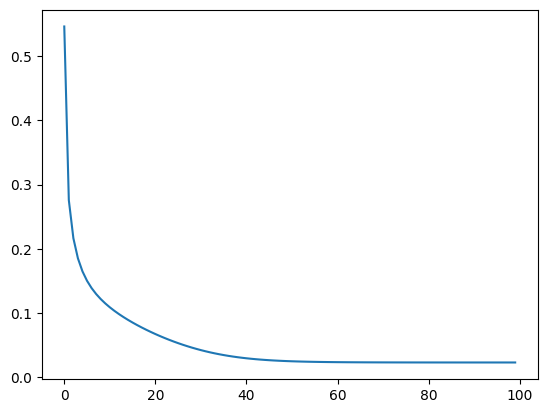

True Mean: 0.0000, True Variance: 1.2500
Obsd Mean: 0.0027, Obsd Variance: 1.2485
Pred Mean: 0.0146, Pred Variance: 1.3087


In [31]:
def explicitLoss(data, m, s, nu, **kwargs):
    temp = [( -(x-m)/(s**2) + x*(nu+1)/(x**2+nu) ) ** 2 for x in data]
    return (1/2) * statistics.mean(temp)

def explicitGradients(data, m, s, nu, **kwargs):
    temp = [(1 / (s**2)) * (-(x-m)/(s**2) + (x*(nu+1))/(x**2+nu)) for x in data]
    gradient_m = statistics.mean(temp)
    temp = [ (-(x-m)/(s**2) + x*(nu+1)/(x**2+nu)) * (x-m) / (s**3) for x in data]
    gradient_s = statistics.mean(temp)
    return gradient_m, gradient_s

excute(data, explicitLoss, explicitGradients, nu=nu)

### Example 1-2. Implicit Score Matching
$$
\begin{align*}
m^{\text{ISM}}, s^{\text{ISM}} &= \argmin_{m, s} \mathbb{E}_{x \sim p(x)} \left[ \frac{1}{2} {\left|\left| \hat{s}_\theta (x) \right|\right|}^2 + \text{tr} \left( \nabla_x \hat{s}_\theta (x) \right)\right] \\
 &= \argmin_{m, s} \mathbb{E}_{x \sim p(x)} \left[ \frac{1}{2} {\left( -\frac{x-m}{s^2} \right)}^2 -\frac{1}{s^2} \right]\\
\nabla_m &= \frac{\partial}{\partial m} \mathbb{E}_{x \sim p(x)} \left[ \frac{1}{2} {\left( -\frac{x-m}{s^2} \right)}^2 -\frac{1}{s^2} \right] = \mathbb{E}_{x \sim p(x)} \left[ - \frac{x-m}{s^4} \right] \\
\nabla_s &= \frac{\partial}{\partial s} \mathbb{E}_{x \sim p(x)} \left[ \frac{1}{2} {\left( -\frac{x-m}{s^2} \right)}^2 -\frac{1}{s^2} \right] = \mathbb{E}_{x \sim p(x)} \left[ -2\frac{{(x-m)}^2}{s^5} + \frac{2}{s^3} \right]
\end{align*}
$$

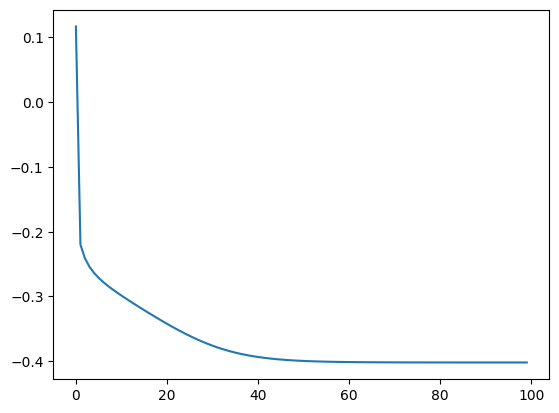

True Mean: 0.0000, True Variance: 1.2500
Obsd Mean: 0.0050, Obsd Variance: 1.2440
Pred Mean: 0.0101, Pred Variance: 1.2861


In [34]:
def implicitLoss(data, m, s, **kwargs):
    temp = [((1/2) * ((-(x-m)/(s**2))**2) - (1 / (s**2))) for x in data]
    return statistics.mean(temp)

def implicitGradients(data, m, s, **kwargs):
    temp = [(-(x-m) / (s**4)) for x in data]
    gradient_m = statistics.mean(temp)
    temp = [(-2 * ((x-m)**2) / (s**5))+(2 / (s**3)) for x in data]
    gradient_s = statistics.mean(temp)
    return gradient_m, gradient_s

excute(data, implicitLoss, implicitGradients, nu=nu)

### Example 1-3. Denoising Score Matching
$$
\begin{align*}
m^{\text{DSM}}, s^{\text{DSM}} &= \argmin_{m, s} \frac{1}{2} \mathbb{E}_{x \sim p(x), \epsilon \sim \mathcal{N}(0, \sigma^2)} \left[ {\left|\left| \hat{s}_\theta(x + \epsilon) + \frac{1}{\sigma^2} \epsilon \right|\right|}^2 \right] \\
 &= \argmin_{m, s} \frac{1}{2} \mathbb{E}_{x \sim p(x)} \left[ \mathbb{E}_{\epsilon \sim \mathcal{N}(0, \sigma^2)} \left[ {\left( -\frac{x + \epsilon - m}{s^2} + \frac{1}{\sigma^2} \epsilon \right)}^2 \right] \right] \\
 &= \argmin_{m, s} \frac{1}{2} \mathbb{E}_{x \sim p(x)} \left[ \mathbb{V}_{\epsilon \sim \mathcal{N}(0, \sigma^2)} \left[ -\frac{x + \epsilon - m}{s^2} + \frac{1}{\sigma^2} \epsilon \right] + {\left( \mathbb{E}_{\epsilon \sim \mathcal{N}(0, \sigma^2)} \left[ -\frac{x + \epsilon - m}{s^2} + \frac{1}{\sigma^2} \epsilon \right] \right)}^2 \right] \\
 &= \argmin_{m, s} \frac{1}{2} \mathbb{E}_{x \sim p(x)} \left[ {\left( -\frac{\sigma^2}{s^2}+1 \right)} + {\left( -\frac{x-m}{s^2} \right)}^2 \right] \\
\nabla_m &= \frac{\partial}{\partial m} \frac{1}{2} \mathbb{E}_{x \sim p(x)} \left[ {\left( -\frac{\sigma^2}{s^2}+1 \right)} + {\left( -\frac{x-m}{s^2} \right)}^2 \right] = \mathbb{E}_{x \sim p(x)} \left[ \frac{1}{s^2} {\left( -\frac{x-m}{s^2} \right)} \right] \\
\nabla_s &= \frac{\partial}{\partial s} \frac{1}{2} \mathbb{E}_{x \sim p(x)} \left[ {\left( -\frac{\sigma^2}{s^2}+1 \right)} + {\left( -\frac{x-m}{s^2} \right)}^2 \right] = \mathbb{E}_{x \sim p(x)} \left[ \frac{\sigma^2}{s^3} -2\frac{{(x-m)}^2}{s^5} \right] \\
\end{align*}
$$

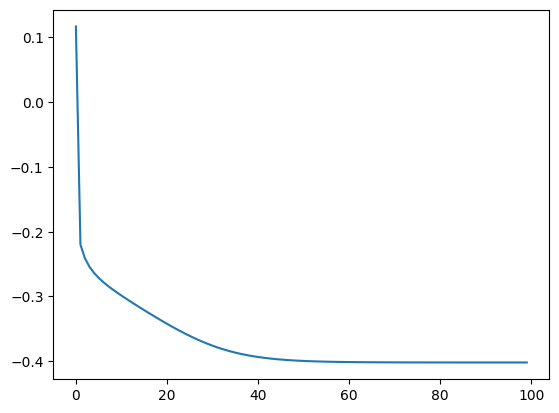

True Mean: 0.0000, True Variance: 1.2500
Obsd Mean: 0.0050, Obsd Variance: 1.2440
Pred Mean: 0.0072, Pred Variance: 1.2802


In [35]:
def denoisingLoss(data, m, s, sigma, **kwargs):
    temp = [(-(sigma**2)/(s**2) + 1) + (-(x-m)/(s**2))**2 for x in data]

def noisingGradients(data, m, s, sigma, **kwargs):
    temp = [(1 / (s**2)) * (-(x-m) / (s**2)) for x in data]
    gradient_m = statistics.mean(temp)
    temp = [((sigma**2) / (s**3)) - 2 * ((x-m)**2) / (s**5) for x in data]
    gradient_s = statistics.mean(temp)
    return gradient_m, gradient_s

def implicitGradients(data, m, s, sigma, **kwargs):
    temp = [(-(x-m) / (s**4)) for x in data]
    gradient_m = statistics.mean(temp)
    temp = [(-2 * ((x-m)**2) / (s**5))+(2 / (s**3)) for x in data]
    gradient_s = statistics.mean(temp)
    return gradient_m, gradient_s

excute(data, implicitLoss, implicitGradients, nu=nu)